In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow import keras

In [5]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")

In [6]:
train["file_path"] = train["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [7]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 224
batch_size = 128
epochs = 100
train_on_fold = None # Which Fold to train, train on all folds if None
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

In [9]:
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image

In [10]:
def preprocess_training(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = data_augment(image)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

def preprocess_validation(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

In [31]:
def base_model():
    weights_path = '../input/d/alexisbcook/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    resnet = tf.keras.applications.resnet50.ResNet50(weights=weights_path ,include_top=False, input_shape=(224,224,3))
    resnet.trainable = False
    return resnet

In [32]:
resnet = base_model()

In [33]:
def get_tabular_model(inputs):
    width = 32
    depth = 3
    activation = "relu"
    kernel_regularizer = keras.regularizers.l2()
    x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(inputs)
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation,
            kernel_regularizer=kernel_regularizer
        )(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.Concatenate()([x, inputs])
    return x

In [34]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = resnet(image_inputs)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    #for _ in range(1):
    #    image_x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2())(image_x)
    image_x = tf.keras.layers.Dropout(0.5)(image_x)
    tabular_x = get_tabular_model(tabular_inputs)
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

In [35]:
show_architecture = False
if show_architecture:
    model = get_model()
    tf.keras.utils.plot_model(model, show_shapes=True)
    print(model.summary())
    image = np.random.normal(size=(1, image_size, image_size, 3))
    tabular = np.random.normal(size=(1, len(tabular_columns)))
    print(image.shape, tabular.shape)
    print(model((image, tabular)).shape)

Epoch 1/100


2021-11-28 05:23:34.864070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-28 05:23:45.355945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 485 of 512
2021-11-28 05:23:45.891794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-11-28 05:23:50.486912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - 184s 3s/step - loss: 732.5446 - rmse: 27.0513 - val_loss: 484.1229 - val_rmse: 21.9864


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 15s 240ms/step - loss: 465.7023 - rmse: 21.5645 - val_loss: 467.4640 - val_rmse: 21.6060
Epoch 3/100
62/62 [==============================] - 15s 240ms/step - loss: 447.9403 - rmse: 21.1496 - val_loss: 449.3757 - val_rmse: 21.1837
Epoch 4/100
62/62 [==============================] - 15s 241ms/step - loss: 428.7936 - rmse: 20.6922 - val_loss: 434.4894 - val_rmse: 20.8293
Epoch 5/100
62/62 [==============================] - 15s 240ms/step - loss: 413.8180 - rmse: 20.3269 - val_loss: 424.1777 - val_rmse: 20.5799
Epoch 6/100
62/62 [==============================] - 15s 240ms/step - loss: 402.4810 - rmse: 20.0457 - val_loss: 416.7414 - val_rmse: 20.3980
Epoch 7/100
62/62 [==============================] - 15s 240ms/step - loss: 394.8311 - rmse: 19.8534 - val_loss: 410.6805 - val_rmse: 20.2483
Epoch 8/100
62/62 [==============================] - 15s 240ms/step - loss: 388.9591 - rmse: 19.7043 - val_loss: 406.0559 - val_rmse: 20.1330
Epoch 

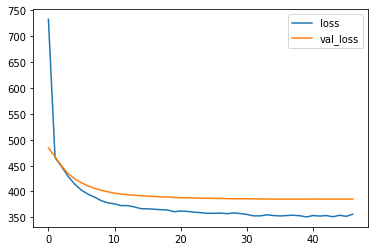

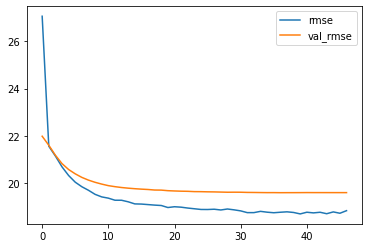

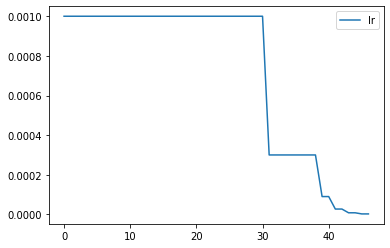

Epoch 1/100


2021-11-28 05:40:37.764303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 494 of 512
2021-11-28 05:40:38.183816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


62/62 [==============================] - 165s 2s/step - loss: 736.0857 - rmse: 27.1170 - val_loss: 444.8899 - val_rmse: 21.0761


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 15s 240ms/step - loss: 470.4530 - rmse: 21.6754 - val_loss: 428.2140 - val_rmse: 20.6789
Epoch 3/100
62/62 [==============================] - 15s 240ms/step - loss: 452.1551 - rmse: 21.2501 - val_loss: 411.9844 - val_rmse: 20.2830
Epoch 4/100
62/62 [==============================] - 15s 240ms/step - loss: 432.8565 - rmse: 20.7911 - val_loss: 400.3428 - val_rmse: 19.9938
Epoch 5/100
62/62 [==============================] - 15s 242ms/step - loss: 420.3465 - rmse: 20.4879 - val_loss: 390.9995 - val_rmse: 19.7584
Epoch 6/100
62/62 [==============================] - 15s 240ms/step - loss: 406.9302 - rmse: 20.1574 - val_loss: 383.6459 - val_rmse: 19.5710
Epoch 7/100
62/62 [==============================] - 15s 241ms/step - loss: 399.2045 - rmse: 19.9644 - val_loss: 378.3950 - val_rmse: 19.4358
Epoch 8/100
62/62 [==============================] - 15s 240ms/step - loss: 394.6456 - rmse: 19.8492 - val_loss: 374.3770 - val_rmse: 19.3315
Epoch 

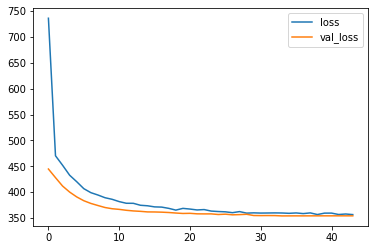

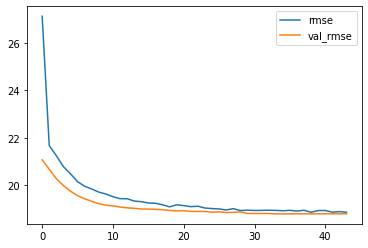

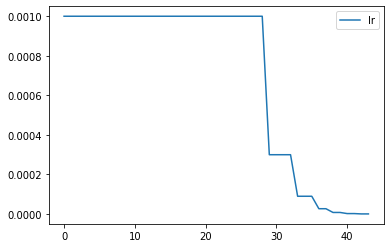

Epoch 1/100
62/62 [==============================] - 159s 2s/step - loss: 749.1472 - rmse: 27.3566 - val_loss: 481.1961 - val_rmse: 21.9200


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 15s 241ms/step - loss: 462.8917 - rmse: 21.4996 - val_loss: 466.1270 - val_rmse: 21.5756
Epoch 3/100
62/62 [==============================] - 15s 240ms/step - loss: 446.9264 - rmse: 21.1264 - val_loss: 445.9103 - val_rmse: 21.1028
Epoch 4/100
62/62 [==============================] - 15s 241ms/step - loss: 430.2554 - rmse: 20.7286 - val_loss: 427.7248 - val_rmse: 20.6676
Epoch 5/100
62/62 [==============================] - 15s 241ms/step - loss: 418.6192 - rmse: 20.4460 - val_loss: 413.3722 - val_rmse: 20.3172
Epoch 6/100
62/62 [==============================] - 15s 240ms/step - loss: 409.0822 - rmse: 20.2111 - val_loss: 402.8645 - val_rmse: 20.0565
Epoch 7/100
62/62 [==============================] - 15s 241ms/step - loss: 400.5150 - rmse: 19.9976 - val_loss: 394.8622 - val_rmse: 19.8555
Epoch 8/100
62/62 [==============================] - 15s 240ms/step - loss: 393.8803 - rmse: 19.8305 - val_loss: 388.4241 - val_rmse: 19.6921
Epoch 

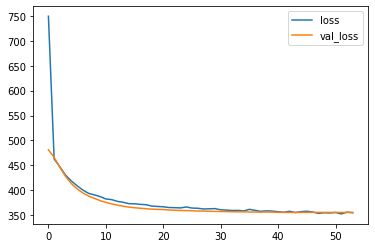

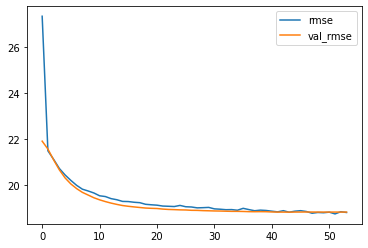

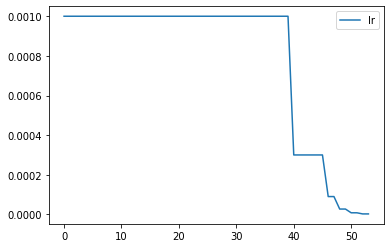

Epoch 1/100


2021-11-28 06:15:27.570582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 441 of 512
2021-11-28 06:15:28.922831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


62/62 [==============================] - 175s 3s/step - loss: 738.9654 - rmse: 27.1699 - val_loss: 488.9234 - val_rmse: 22.0954


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 15s 240ms/step - loss: 466.6791 - rmse: 21.5872 - val_loss: 468.2286 - val_rmse: 21.6238
Epoch 3/100
62/62 [==============================] - 15s 241ms/step - loss: 448.1310 - rmse: 21.1543 - val_loss: 446.2784 - val_rmse: 21.1106
Epoch 4/100
62/62 [==============================] - 15s 241ms/step - loss: 429.9897 - rmse: 20.7213 - val_loss: 428.6224 - val_rmse: 20.6882
Epoch 5/100
62/62 [==============================] - 15s 240ms/step - loss: 415.2145 - rmse: 20.3615 - val_loss: 415.8978 - val_rmse: 20.3781
Epoch 6/100
62/62 [==============================] - 15s 241ms/step - loss: 404.8689 - rmse: 20.1055 - val_loss: 406.4280 - val_rmse: 20.1439
Epoch 7/100
62/62 [==============================] - 15s 240ms/step - loss: 398.0213 - rmse: 19.9339 - val_loss: 399.3197 - val_rmse: 19.9660
Epoch 8/100
62/62 [==============================] - 15s 241ms/step - loss: 391.5328 - rmse: 19.7698 - val_loss: 393.8625 - val_rmse: 19.8282
Epoch 

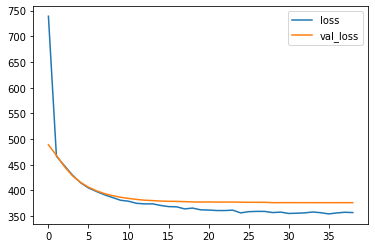

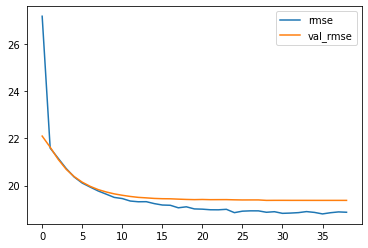

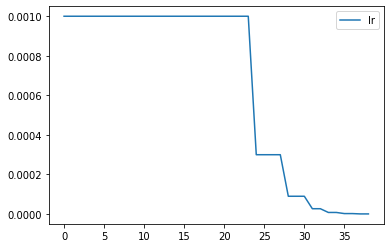

Epoch 1/100
62/62 [==============================] - 156s 2s/step - loss: 730.5678 - rmse: 27.0146 - val_loss: 457.5396 - val_rmse: 21.3729


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
62/62 [==============================] - 15s 241ms/step - loss: 467.5789 - rmse: 21.6074 - val_loss: 437.8321 - val_rmse: 20.9084
Epoch 3/100
62/62 [==============================] - 15s 240ms/step - loss: 448.6993 - rmse: 21.1669 - val_loss: 418.7721 - val_rmse: 20.4479
Epoch 4/100
62/62 [==============================] - 15s 241ms/step - loss: 432.5736 - rmse: 20.7826 - val_loss: 402.5283 - val_rmse: 20.0467
Epoch 5/100
62/62 [==============================] - 15s 241ms/step - loss: 416.5083 - rmse: 20.3922 - val_loss: 390.8152 - val_rmse: 19.7521
Epoch 6/100
62/62 [==============================] - 15s 241ms/step - loss: 408.3826 - rmse: 20.1917 - val_loss: 381.9521 - val_rmse: 19.5260
Epoch 7/100
62/62 [==============================] - 15s 240ms/step - loss: 400.0494 - rmse: 19.9838 - val_loss: 375.1590 - val_rmse: 19.3507
Epoch 8/100
62/62 [==============================] - 15s 240ms/step - loss: 393.9565 - rmse: 19.8301 - val_loss: 369.6447 - val_rmse: 19.2069
Epoch 

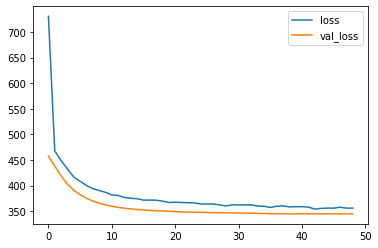

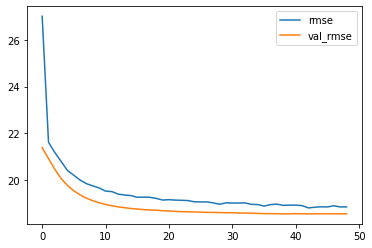

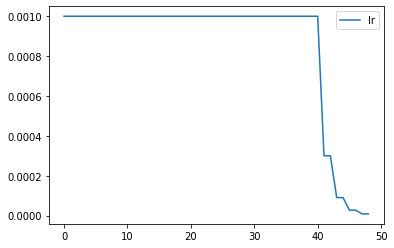

In [36]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_on_fold != None and train_on_fold != index:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess_training).shuffle(512).batch(batch_size).cache().prefetch(AUTO)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess_validation).batch(batch_size).cache().prefetch(AUTO)
    model = get_model()
    model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("rmse", "val_rmse"),["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

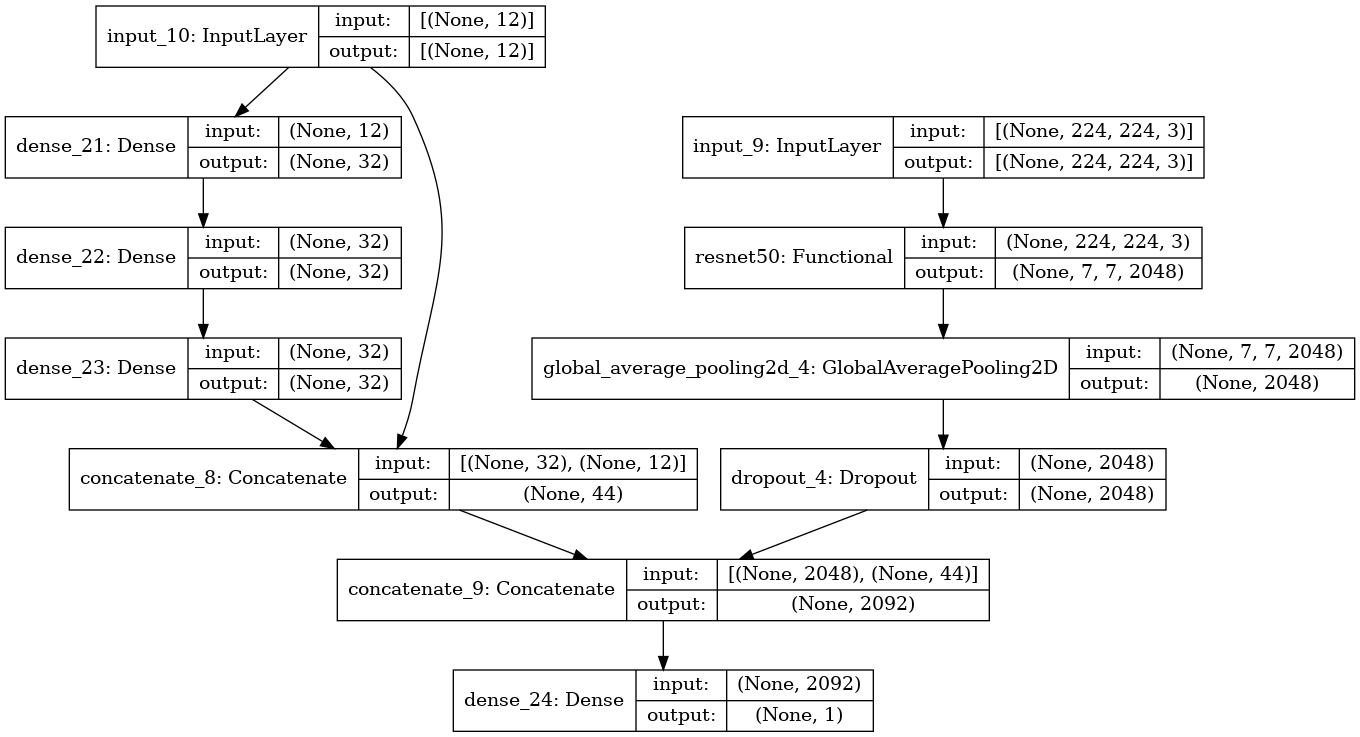

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [38]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [39]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [40]:
total_results = []
for model in models:
    total_results.append(model.predict(test_ds).reshape(-1))
results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

In [41]:
sample_submission.head(5)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,34.222736
1,43a2262d7738e3d420d453815151079e,32.092136
2,4e429cead1848a298432a0acad014c9d,35.531914
3,80bc3ccafcc51b66303c2c263aa38486,29.531809
4,8f49844c382931444e68dffbe20228f4,23.557999
